<a href="https://www.kaggle.com/code/klyushnik/s5e5-blend-work-0-05799?scriptVersionId=238536152" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/calories-burnt-prediction/calories.csv
/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# Description

![how-many-calories-do-i-burn-every-day-3495464-final-dc03506ae07344f5a7ebeb4d3da0d90d.jpg](https://www.verywellfit.com/thmb/1F8NNi71E1nEd3V_INJah2XWjas=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/how-many-calories-do-i-burn-every-day-3495464-final-dc03506ae07344f5a7ebeb4d3da0d90d.jpg)

**My name is Alexander and I present to your attention my vision of the dataset, model selection and results.**

**Your Goal:** Your goal is to predict how many calories were burned during a workout.

**Evaluation**

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:

$$
\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(y_i + 1) - \log(\hat{y}_i + 1) \right)^2}
$$

# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_regression,
    SequentialFeatureSelector,
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    StratifiedGroupKFold,
    RepeatedStratifiedKFold,
    RepeatedKFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
)
from sklearn.linear_model import (
    SGDOneClassSVM,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    IsolationForest,
    BaggingRegressor,
    RandomForestRegressor,
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error, 
    r2_score,
    make_scorer
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import clone_model
import keras
from keras_tuner import RandomSearch
from keras import layers
from keras.layers import (
    BatchNormalization,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from tensorflow.keras.models import Sequential
from keras import backend as K
import keras_tuner
from keras_tuner import Hyperband
from functools import partial

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from category_encoders import TargetEncoder, MEstimateEncoder
#from cuml.preprocessing import TargetEncoder

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

from functools import partial

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

2025-05-08 09:50:05.220449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746697805.519250      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746697805.601665      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if np.any(y_true < 0) or np.any(y_pred < 0):
        raise ValueError("y_true and y_pred must not contain negative values!")
    
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    
    squared_log_errors = (log_true - log_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    return np.sqrt(mean_squared_log_error)

def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

def replace_outliers_with_mean(df, threshold=3):

    df_clean = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit')) 
        
        mean_val = df[col][z_scores <= threshold].mean()
        
        df_clean[col] = np.where(z_scores > threshold, mean_val, df[col])
        
    return df_clean

# Data

## Load 

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

train.shape, test.shape

((750000, 9), (250000, 8))

In [5]:
calories = pd.read_csv('/kaggle/input/calories-burnt-prediction/calories.csv', index_col="User_ID")

calories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 14733363 to 11751526
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
calories = calories.rename(columns={"Gender": "Sex"})

train = pd.concat([train, calories])

train.shape, test.shape

((765000, 9), (250000, 8))

In [7]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

## Info

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 11751526
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         765000 non-null  object 
 1   Age         765000 non-null  int64  
 2   Height      765000 non-null  float64
 3   Weight      765000 non-null  float64
 4   Duration    765000 non-null  float64
 5   Heart_Rate  765000 non-null  float64
 6   Body_Temp   765000 non-null  float64
 7   Calories    765000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 52.5+ MB


In [9]:
train.head(5)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,765000.0,41.447255,15.213677,20.0,28.0,40.0,52.0,79.0
Height,765000.0,174.693126,12.854173,123.0,164.0,174.0,185.0,222.0
Weight,765000.0,75.142162,14.004122,36.0,63.0,74.0,87.0,132.0
Duration,765000.0,15.423163,8.353421,1.0,8.0,15.0,23.0,30.0
Heart_Rate,765000.0,95.484672,9.452476,67.0,88.0,95.0,103.0,128.0
Body_Temp,765000.0,40.036041,0.779863,37.1,39.6,40.3,40.7,41.5
Calories,765000.0,88.307424,62.396760,1.0,34.0,77.0,136.0,314.0


**On average, a 40-year-old person who is 175 cm tall and weighs 75 kg exercises for 15 minutes and burns 88 calories.**

In [11]:
duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

train = train.drop_duplicates()

Number of duplicates: 2893


In [12]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Sex - 0%
Age - 0%
Height - 0%
Weight - 0%
Duration - 0%
Heart_Rate - 0%
Body_Temp - 0%
Calories - 0%


## Optimize memory

In [13]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 52.3297 Mb - after 29.7989 Mb (43.1%).
Memory usage size: before 13.3516 Mb - after 6.9143 Mb (48.2%).


# EDA

## Numerical feature

### Hist

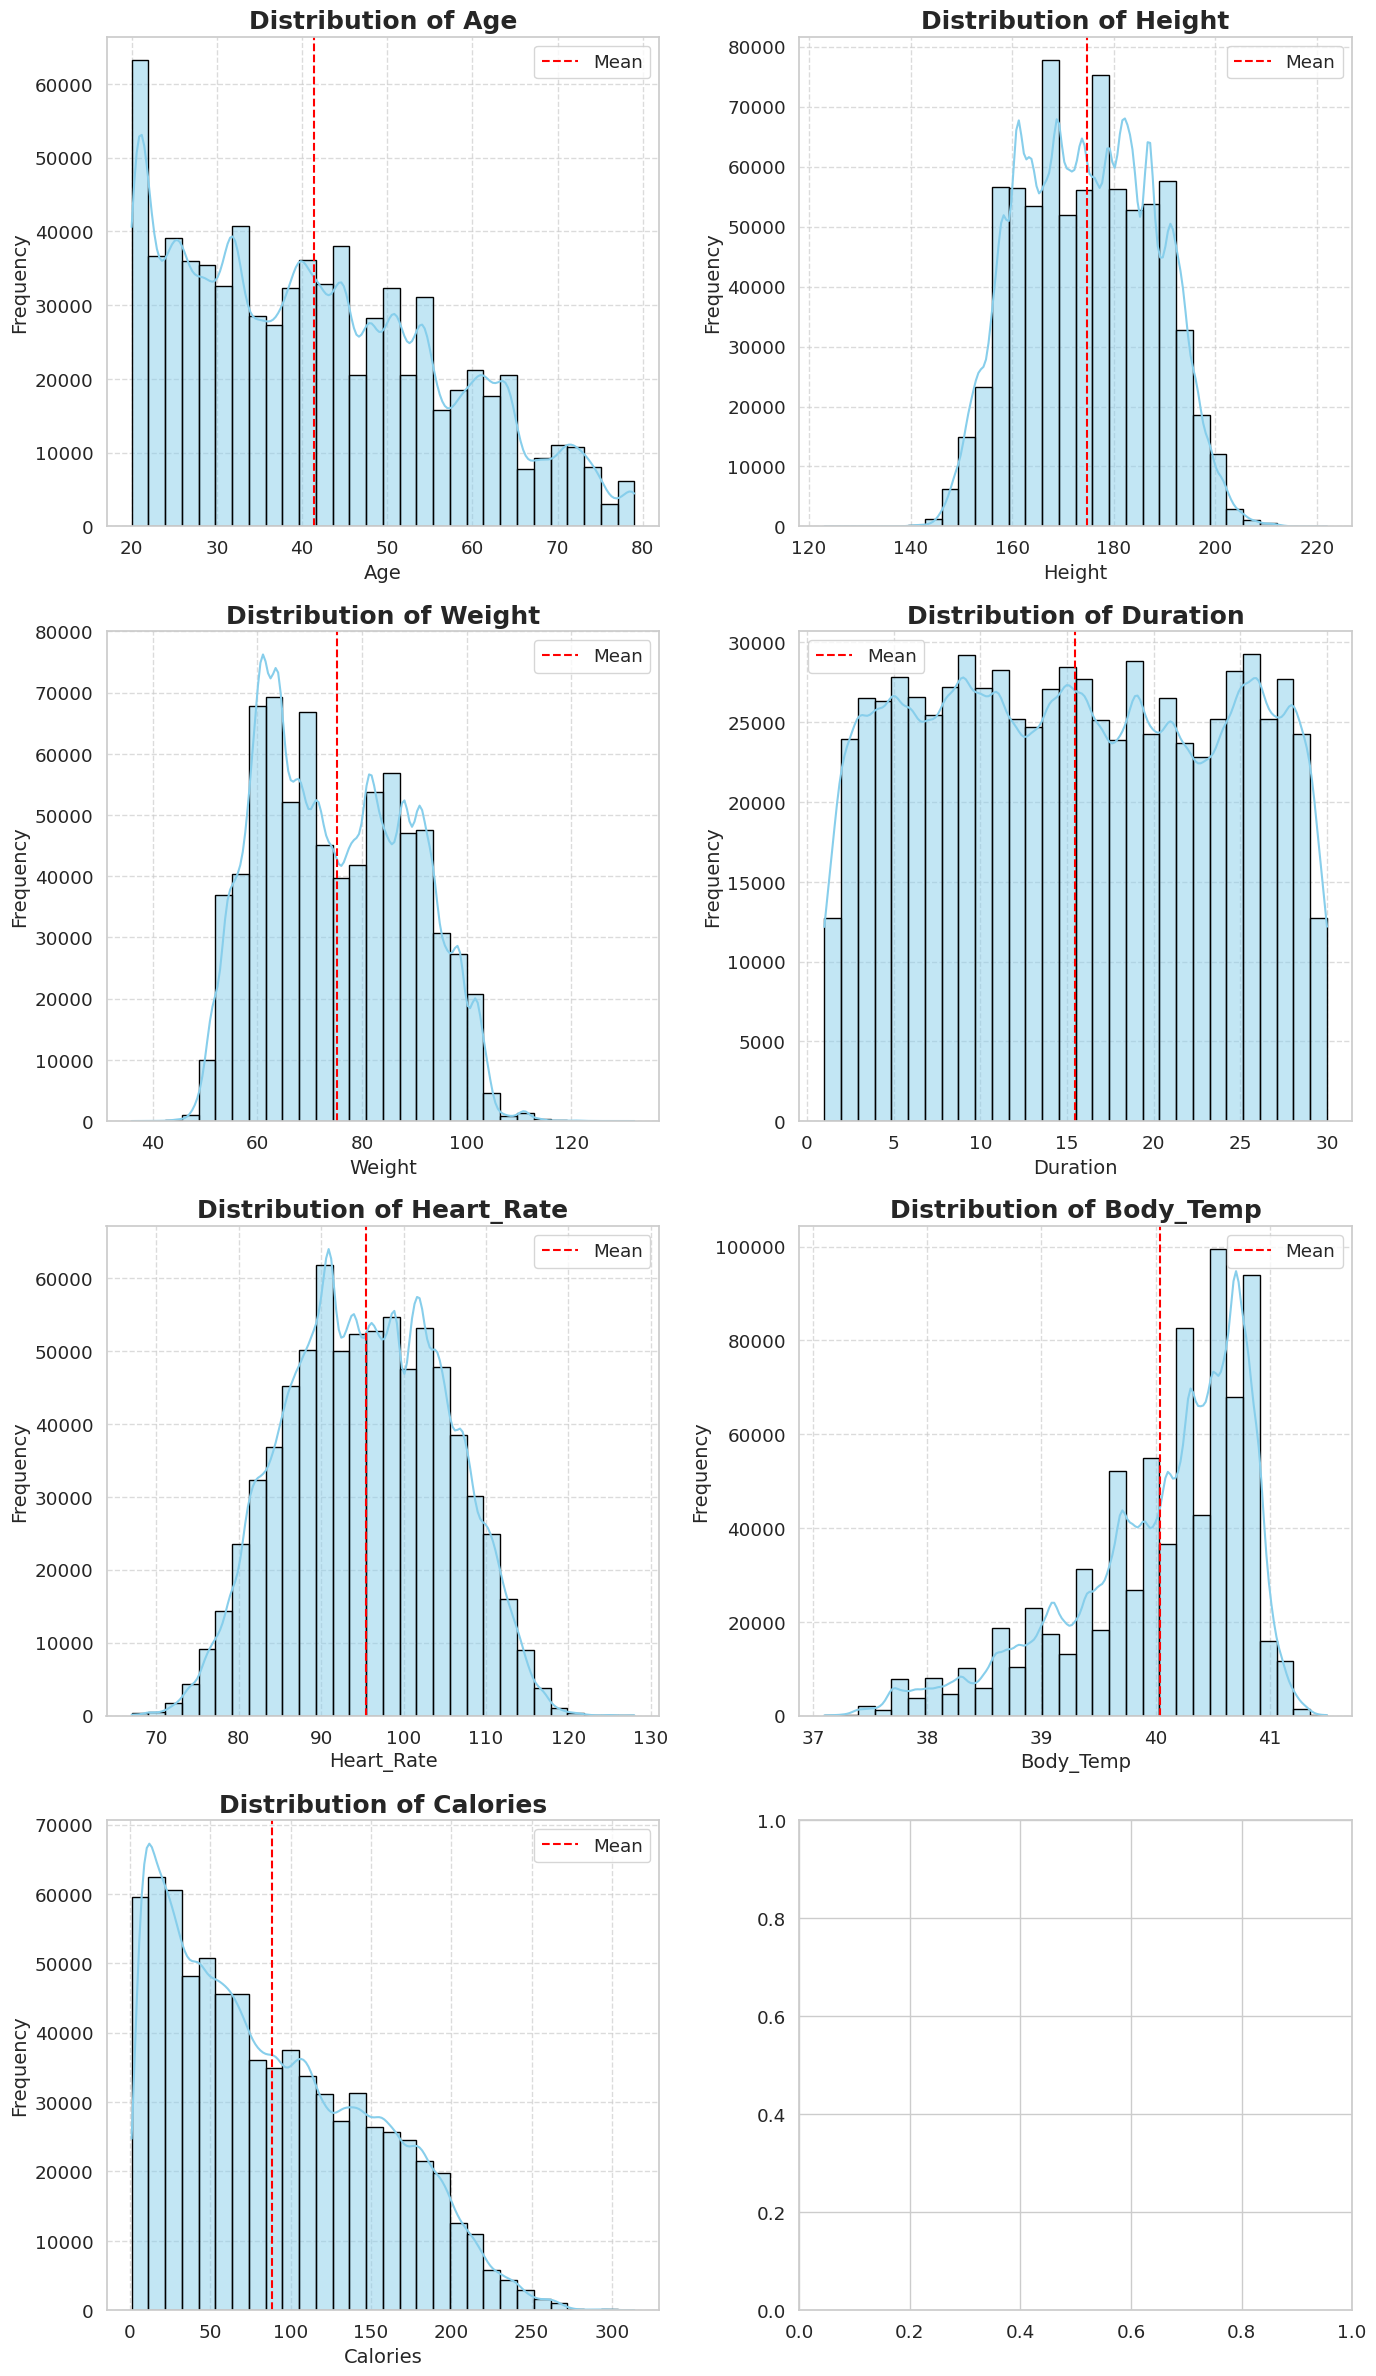

In [14]:
plot_numerical_features(train)

### Box

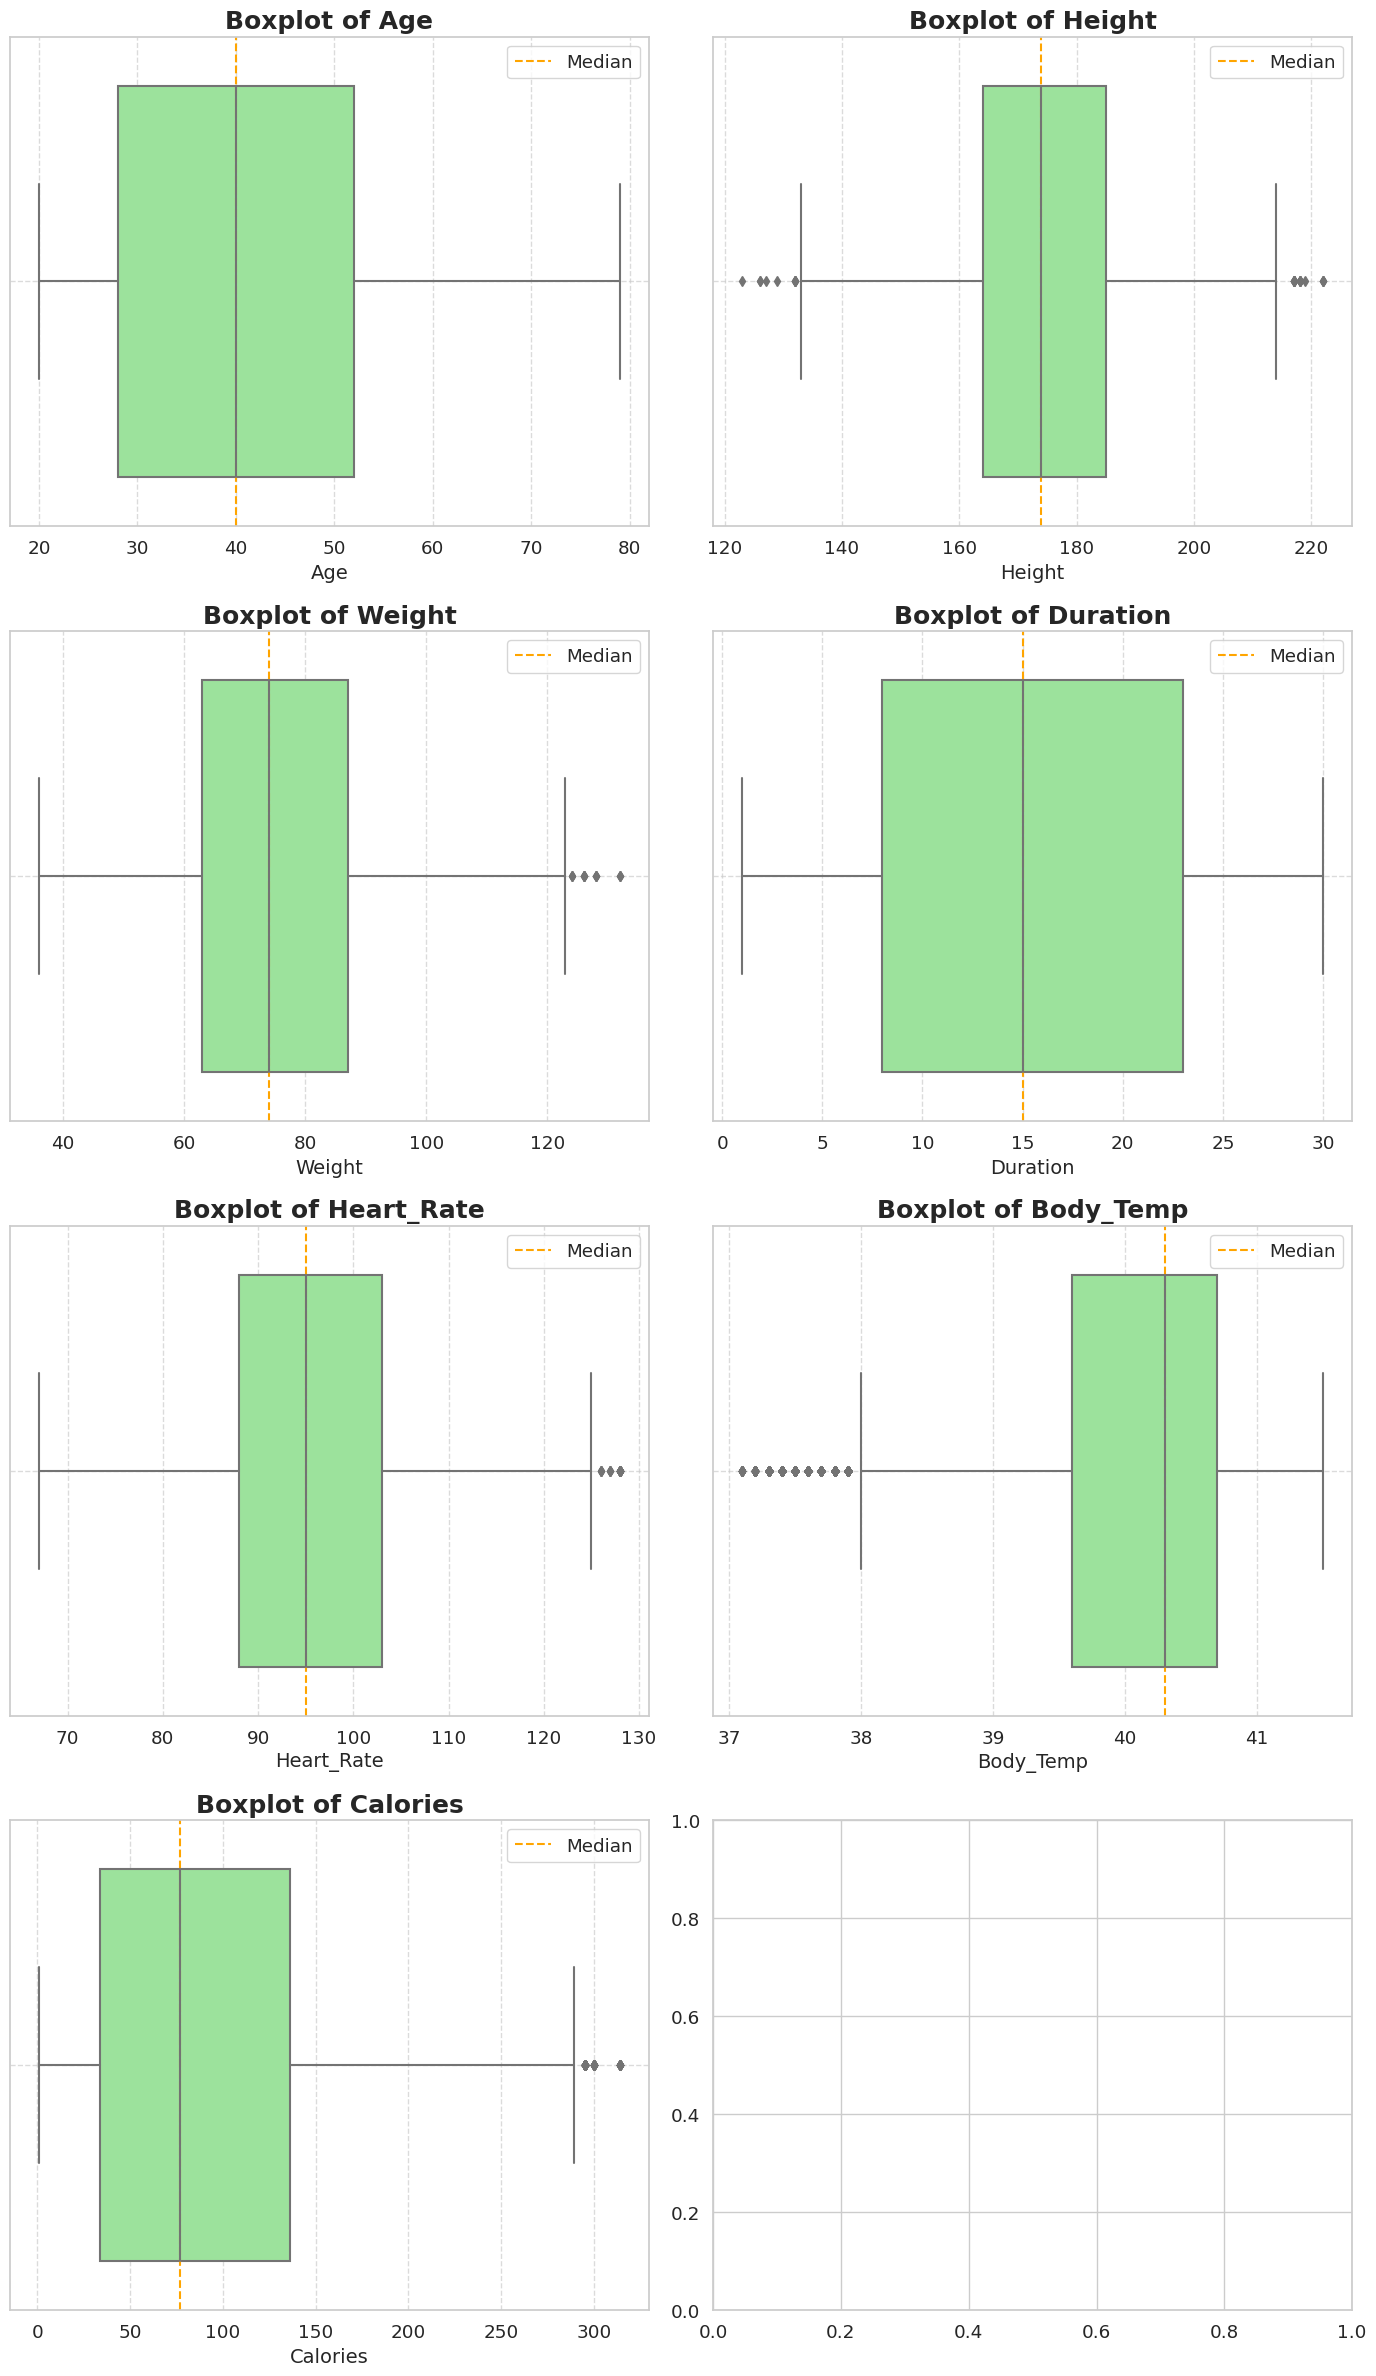

In [15]:
plot_numerical_boxplots(train)

### Q_Q

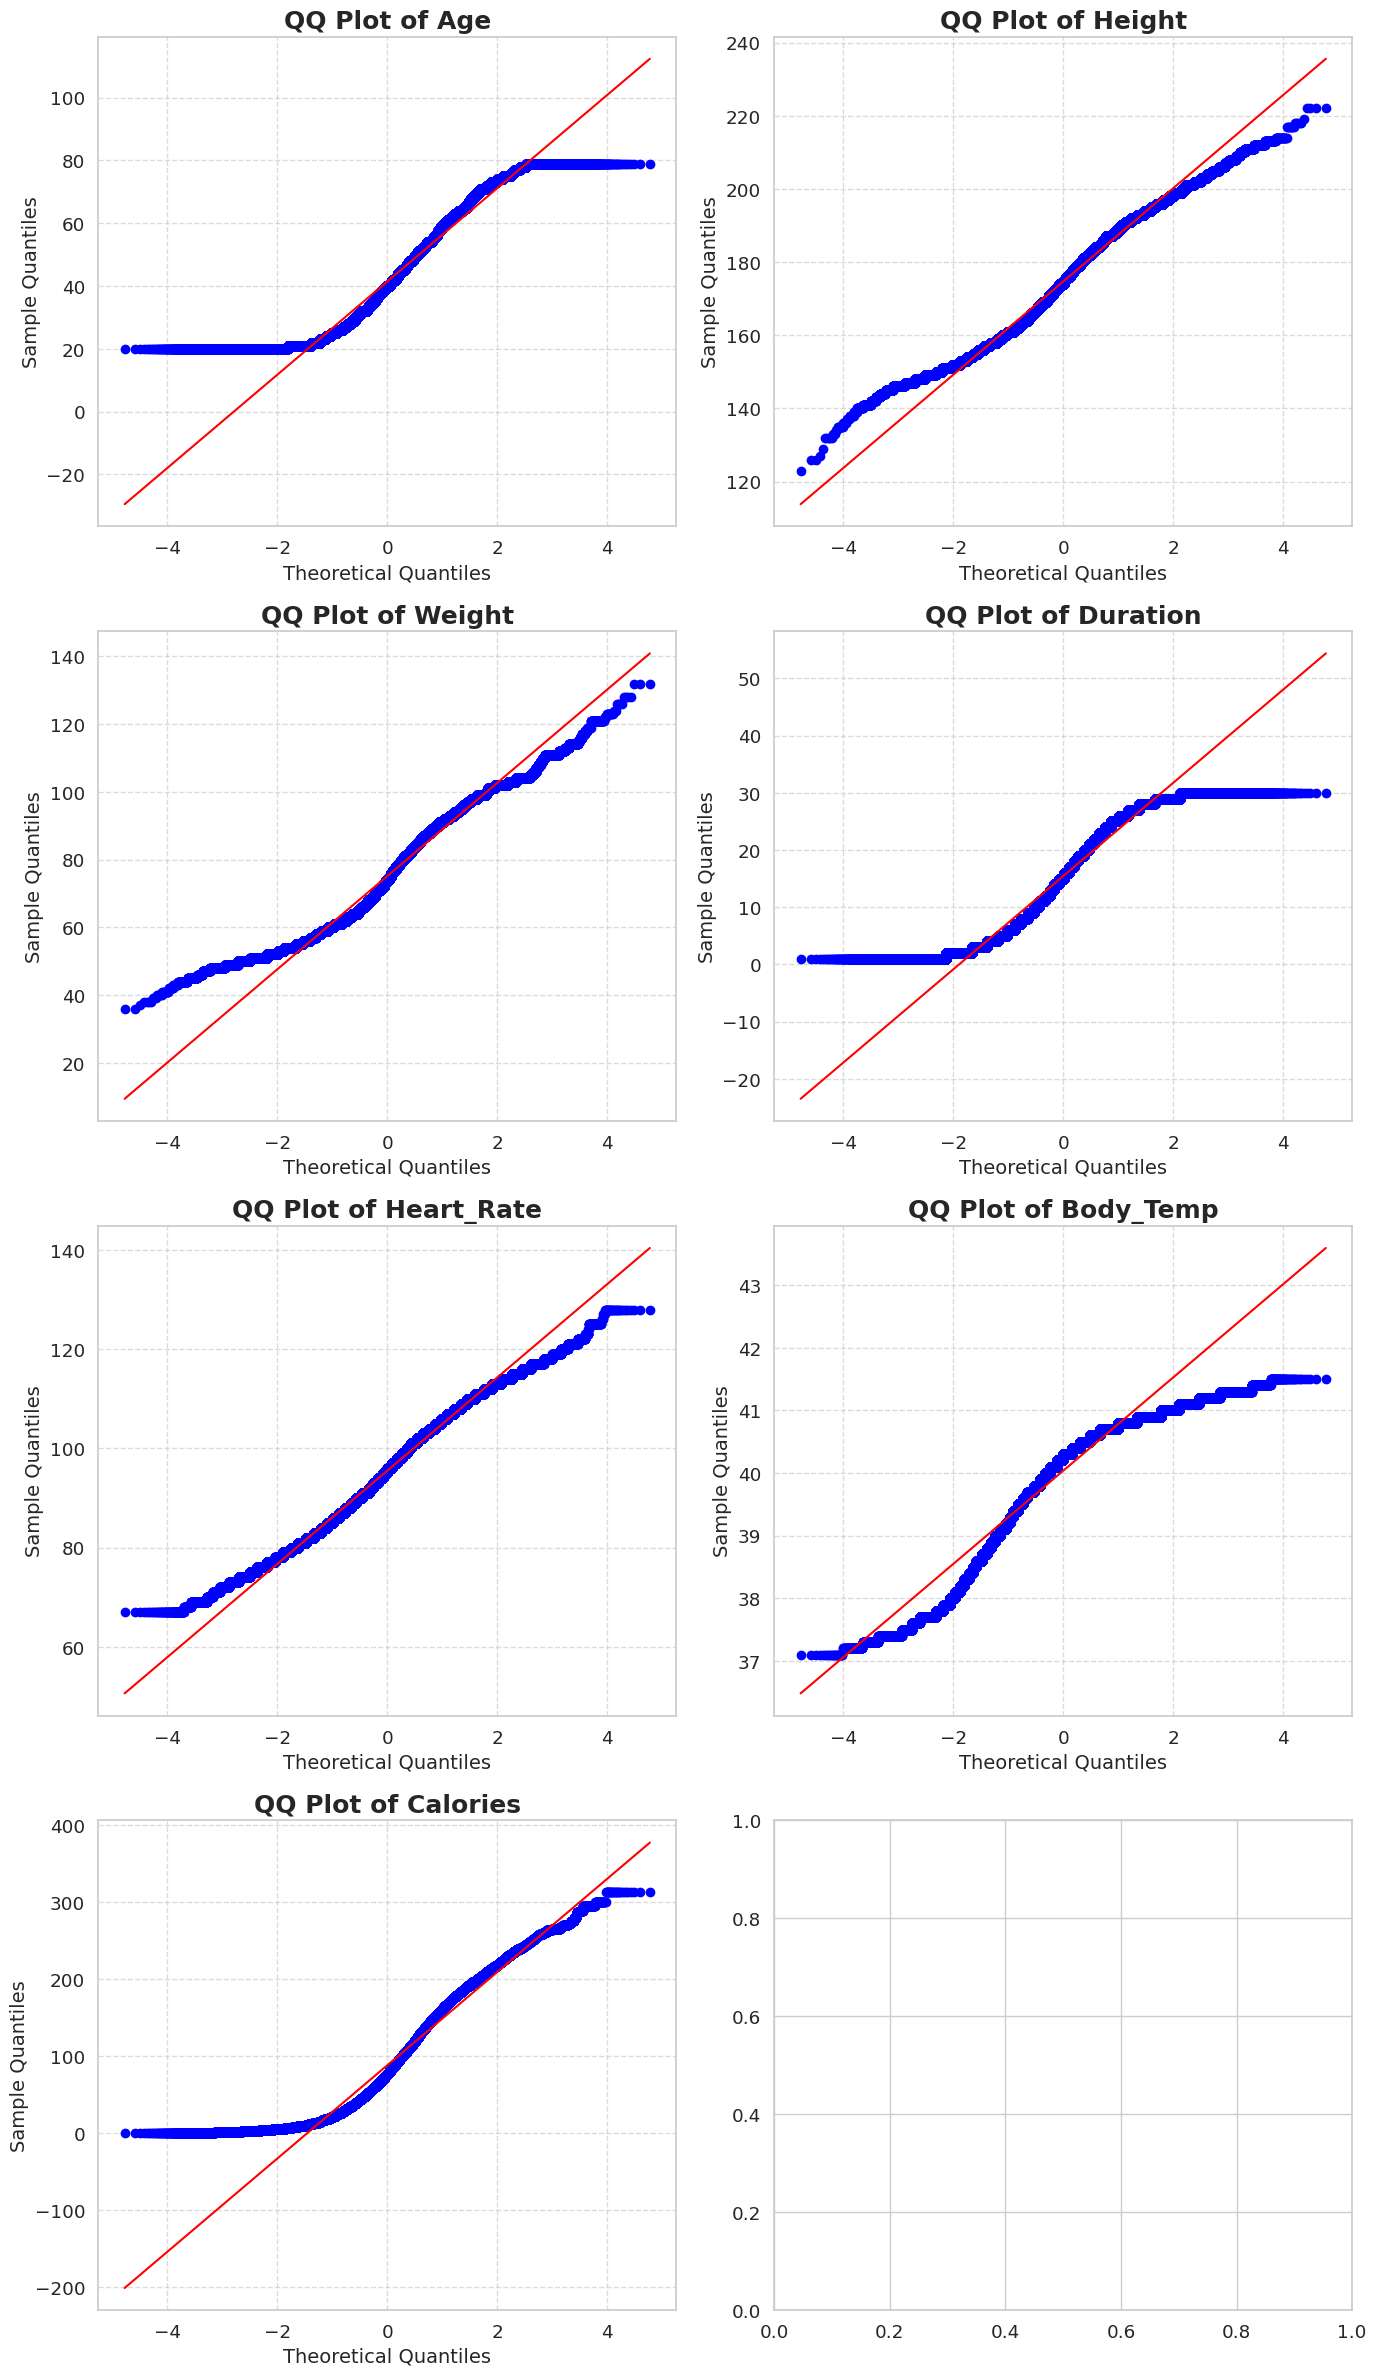

In [16]:
plot_qq_plot(train)

### Correlation matrix

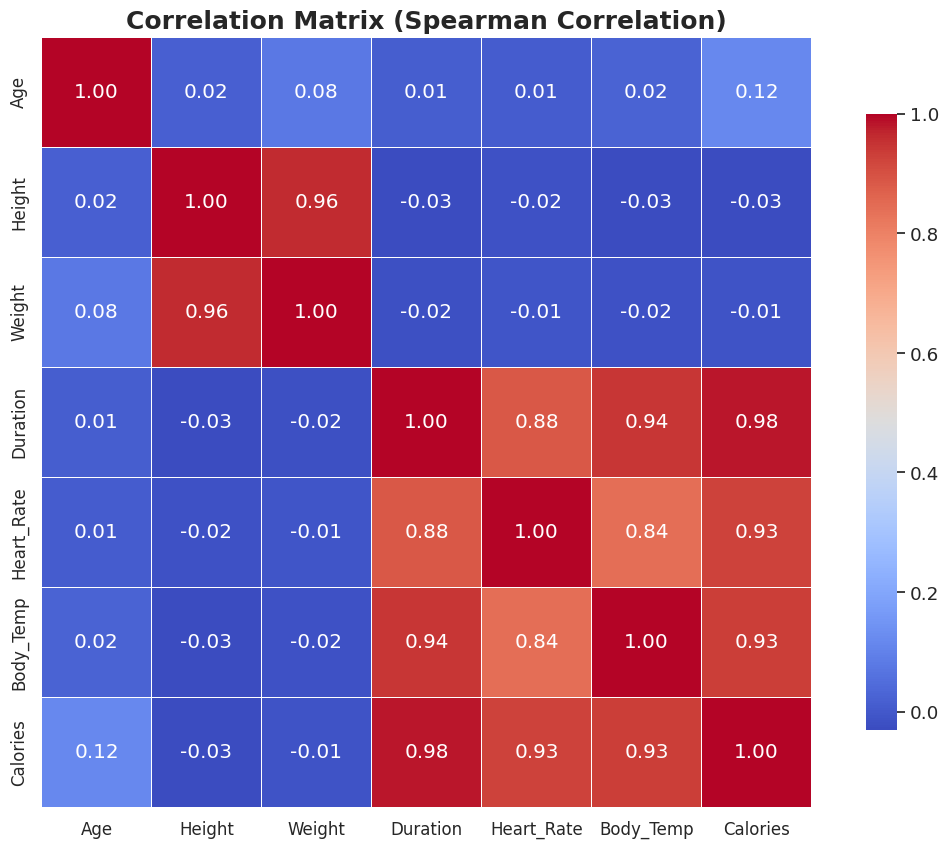

In [17]:
plot_correlation_matrix(train)

## VIF

In [18]:
X = sm.add_constant(train.select_dtypes(include=[np.number]).iloc [:, 1:])

VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

     Variable           VIF
0       const  16284.985849
1      Height     12.438762
2      Weight     12.573605
3    Duration     25.243624
4  Heart_Rate      6.082046
5   Body_Temp      6.404611
6    Calories     20.847990


## Categorical features

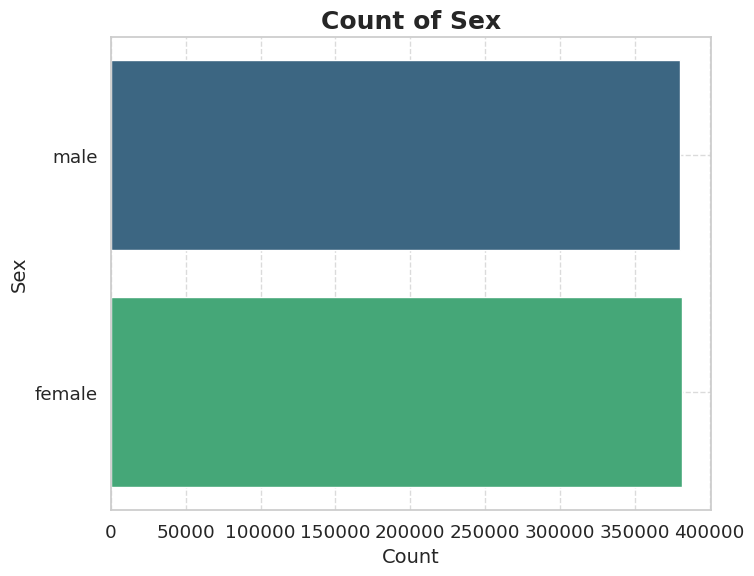

In [19]:
plot_categorical_features(train)

# New features

In [20]:
categorize_variable(train, 'Age', ["young", "middle age", 'old'])
categorize_variable(train, 'Height', ["short", "middle", 'high'])
categorize_variable(train, 'Weight', ["thin", "normal", 'fat'])
categorize_variable(train, 'Duration', ["short", "mean", 'long'])
categorize_variable(train, 'Heart_Rate', ["low", "normal", 'high'])


categorize_variable(test, 'Age', ["young", "middle age", 'old'])
categorize_variable(test, 'Height', ["short", "middle", 'high'])
categorize_variable(test, 'Weight', ["thin", "normal", 'fat'])
categorize_variable(test, 'Duration', ["short", "mean", 'long'])
categorize_variable(test, 'Heart_Rate', ["low", "normal", 'high'])

train['BMI'] = train['Weight'] / (train['Height'] ** 2)
test['BMI'] = test['Weight'] / (test['Height'] ** 2)


train.shape, test.shape

((762107, 14), (250000, 13))

# X,y make transform

## Target Encode

In [21]:
col = ['Age_group', 'Height_group', 'Weight_group', 'Duration_group',
       'Heart_Rate_group', 'Sex']

TE = MEstimateEncoder(cols=col, m=5.0)

train[col] = TE.fit_transform(train[col], train['Calories'])
test[col] = TE.transform(test[col])

train.shape, test.shape

((762107, 14), (250000, 13))

## Split data, threshold

In [22]:
X = train.drop(columns=['Calories'])
y = train['Calories']
print('before threshold:',X.shape, y.shape)

X = variance_threshold(X,0.01)
list_name = (X.columns)
test = test[list_name]

print('after threshold:',X.shape, y.shape, test.shape)

before threshold: (762107, 13) (762107,)
after threshold: (762107, 12) (762107,) (250000, 12)


## StandardScaler

In [23]:
scaler = RobustScaler()

X[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X[X.select_dtypes(include=[np.number]).columns])
test[X.select_dtypes(include=[np.number]).columns] = scaler.transform(test[X.select_dtypes(include=[np.number]).columns])

X.shape, y.shape, test.shape

((762107, 12), (762107,), (250000, 12))

# Model

## Parametrs

In [24]:
catboost_params = [ 
    
                    {'iterations': 3000, 'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3,
                     'loss_function': 'RMSE', 'border_count': 32, 'bagging_temperature': 1,
                     'random_strength': 1},
    
                   {'iterations': 4000, 'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 5,
                    'loss_function': 'RMSE', 'border_count': 64, 'bagging_temperature': 0.5,
                    'random_strength': 2},
    
                   {'iterations': 2000, 'depth': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 
                    'loss_function': 'RMSE', 'border_count': 16, 'bagging_temperature': 1.5,
                    'random_strength': 0.5}, 
    
                   {'iterations': 2900, 'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 10,
                    'loss_function': 'RMSE', 'border_count': 32, 'bagging_temperature': 0.8,
                    'random_strength': 1.5}, 
    
                   {'iterations': 2300, 'depth': 7, 'learning_rate': 0.02, 'l2_leaf_reg': 7,
                    'loss_function': 'RMSE', 'border_count': 64, 'bagging_temperature': 1,
                    'random_strength': 1},
    
                   {'iterations': 1700, 'depth': 12, 'learning_rate': 0.005, 'l2_leaf_reg': 2, 
                    'loss_function': 'RMSE', 'border_count': 16, 'bagging_temperature': 0.3,
                    'random_strength': 2}, 
    
                   {'iterations': 1900, 'depth': 5, 'learning_rate': 0.04, 'l2_leaf_reg': 4, 
                    'loss_function': 'RMSE','border_count': 48, 'bagging_temperature': 0.7, 
                    'random_strength': 0.8, 'grow_policy': 'SymmetricTree'}, 
    
                   {'iterations': 2400, 'depth': 9, 'learning_rate': 0.025, 'l2_leaf_reg': 6, 
                    'loss_function': 'RMSE', 'border_count': 24, 'random_strength': 1.2, 
                    'bootstrap_type': 'Bernoulli'}
]

xgb_params = [ 
    
                {'n_estimators': 2000, 'max_depth': 6, 'learning_rate': 0.01,
                'subsample': 0.8, 'eval_metric': 'rmse', 'colsample_bytree': 0.8, 
                'gamma': 0, 'min_child_weight': 1},
              
              {'n_estimators': 3000, 'max_depth': 8, 'learning_rate': 0.03,
               'subsample': 0.9, 'eval_metric': 'rmse', 'colsample_bytree': 0.9, 
               'gamma': 0.1, 'min_child_weight': 2},
    
              {'n_estimators': 1900, 'max_depth': 4, 'learning_rate': 0.05,
               'subsample': 0.7, 'eval_metric': 'rmse', 'colsample_bytree': 0.7,
               'gamma': 0.2, 'min_child_weight': 3}, 
    
              {'n_estimators': 4000, 'max_depth': 3, 'learning_rate': 0.005, 
               'subsample': 0.6, 'eval_metric': 'rmse', 'colsample_bytree': 0.6,
               'gamma': 0.3, 'min_child_weight': 1},
    
              {'n_estimators': 2400, 'max_depth': 10, 'learning_rate': 0.02, 
               'subsample': 0.75, 'eval_metric': 'rmse', 'colsample_bytree': 0.75, 
               'gamma': 0.4, 'min_child_weight': 2},
    
              {'n_estimators': 4000, 'max_depth': 12, 'learning_rate': 0.1,
               'subsample': 0.85, 'eval_metric': 'rmse', 'colsample_bytree': 0.85, 
               'gamma': 0.5, 'min_child_weight': 1},
    
              {'n_estimators': 2600, 'max_depth': 7, 'learning_rate': 0.015,
               'subsample': 0.82, 'eval_metric': 'rmse', 'colsample_bytree': 0.82,
               'gamma': 0.15, 'min_child_weight': 2, 'reg_alpha': 0.1, 'reg_lambda': 0.5},
    
              {'n_estimators': 2200, 'max_depth': 9, 'learning_rate': 0.025, 'subsample': 0.88,
               'eval_metric': 'rmse', 'colsample_bytree': 0.88, 'gamma': 0.25, 'min_child_weight': 1,
               'tree_method': 'hist', 'grow_policy': 'lossguide'} 
]

lgbm_params = [ 
    
                {'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01,
                 'num_leaves': 31, 'metric': 'rmse', 'min_data_in_leaf': 20, 
                 'feature_fraction': 0.8, 'bagging_fraction': 0.8},
               
               {'n_estimators': 3000, 'max_depth': 8, 'learning_rate': 0.03, 
                'num_leaves': 63, 'metric': 'rmse', 'min_data_in_leaf': 15, 
                'feature_fraction': 0.9, 'bagging_fraction': 0.9},
               
               {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.05, 
                'num_leaves': 15, 'metric': 'rmse', 'min_data_in_leaf': 10, 
                'feature_fraction': 0.7, 'bagging_fraction': 0.7},
               
               {'n_estimators': 2300, 'max_depth': 12, 'learning_rate': 0.005, 
                'num_leaves': 127, 'metric': 'rmse', 'min_data_in_leaf': 5,
                'feature_fraction': 0.6, 'bagging_fraction': 0.6},
               
               {'n_estimators': 2500, 'max_depth': 6, 'learning_rate': 0.02, 
                'num_leaves': 255, 'metric': 'rmse', 'min_data_in_leaf': 25, 
                'feature_fraction': 0.75, 'bagging_fraction': 0.75}, 
               {'n_estimators': 3000, 'max_depth': 15, 'learning_rate': 0.1,
                'num_leaves': 511, 'metric': 'rmse', 'min_data_in_leaf': 30,
                'feature_fraction': 0.85, 'bagging_fraction': 0.85}, 
               {'n_estimators': 2000, 'max_depth': 7, 'learning_rate': 0.018,
                'num_leaves': 95, 'metric': 'rmse', 'min_data_in_leaf': 18, 
                'feature_fraction': 0.83, 'bagging_fraction': 0.83, 'lambda_l1': 0.1,
                'lambda_l2': 0.2},
    
               {'n_estimators': 2400, 'max_depth': 9, 'learning_rate': 0.035,
                'num_leaves': 191, 'metric': 'rmse', 'min_data_in_leaf': 22,
                'feature_fraction': 0.92, 'bagging_fraction': 0.92, 
                'min_gain_to_split': 0.1, 'boosting_type': 'goss'} 
              ]

hgbm_params = [
    {
        'max_iter': 800,
        'max_depth': 5,
        'learning_rate': 0.01,
        'min_samples_leaf': 20,
        'l2_regularization': 0.1,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 340,
        'max_depth': 8,
        'learning_rate': 0.03,
        'min_samples_leaf': 15,
        'l2_regularization': 0.2,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 500,
        'max_depth': 3,
        'learning_rate': 0.05,
        'min_samples_leaf': 10,
        'l2_regularization': 0.1,
        'max_bins': 128,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 230,
        'max_depth': 12,
        'learning_rate': 0.005,
        'min_samples_leaf': 5,
        'l2_regularization': 0.3,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 250,
        'max_depth': 6,
        'learning_rate': 0.02,
        'min_samples_leaf': 25,
        'l2_regularization': 0.1,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 300,
        'max_depth': 15,
        'learning_rate': 0.1,
        'min_samples_leaf': 30,
        'l2_regularization': 0.2,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 200,
        'max_depth': 7,
        'learning_rate': 0.018,
        'min_samples_leaf': 18,
        'l2_regularization': 0.1,
        'max_bins': 255,
        'max_leaf_nodes': None
    },
    {
        'max_iter': 1000,
        'max_depth': 9,
        'learning_rate': 0.035,
        'min_samples_leaf': 22,
        'l2_regularization': 0.2,
        'max_bins': 255,
        'max_leaf_nodes': None
    }
]


## Model

In [25]:
def create_ensemble(X, y, test, n_folds=5, use_log_transform=True):
    FOLDS = KFold(n_splits=5, shuffle=True, random_state=42)
    
    if use_log_transform:
        y_transformed = np.log1p(y)
        print("Applied log1p transformation to target variable")
    else:
        y_transformed = y.copy()
    
    all_oof = {}
    all_predictions = {}
    models = []
    
    for i, params in enumerate(catboost_params, 1):
        models.append((f'cat_{i}', CatBoostRegressor(**params, verbose=0, thread_count=1)))
    
    for i, params in enumerate(xgb_params, 1):
        models.append((f'xgb_{i}', xgb.XGBRegressor(**params, n_jobs=1)))
    
    for i, params in enumerate(lgbm_params, 1):
        models.append((f'lgb_{i}', LGBMRegressor(**params, verbose=-1, n_jobs=1)))

    for i, params in enumerate(hgbm_params, 1):
        models.append((f'hgb_{i}', HistGradientBoostingRegressor(**params)))
    
    for name, model in models:
        try:
            print(f"\nTraining {name}...")
            oof = np.zeros(len(X))
            pred = np.zeros(len(test))
            
            for fold, (trn_idx, val_idx) in enumerate(FOLDS.split(X, y_transformed)):
                X_train, y_train = X.iloc[trn_idx], y_transformed.iloc[trn_idx]
                X_val, y_val = X.iloc[val_idx], y_transformed.iloc[val_idx]
                
                model.fit(X_train, y_train)
                oof[val_idx] = model.predict(X_val)
                pred += model.predict(test) / FOLDS.n_splits
                
                if use_log_transform:
                    fold_rmsle = rmsle(np.expm1(y_val), np.expm1(oof[val_idx]))
                else:
                    fold_rmsle = rmsle(y_val, oof[val_idx])
                print(f'{name} - Fold {fold} RMSLE: {fold_rmsle:.4f}')
            
            all_oof[name] = oof
            all_predictions[name] = pred
            
            if use_log_transform:
                full_rmsle = rmsle(y, np.expm1(oof))
            else:
                full_rmsle = rmsle(y, oof)
            print(f'{name} - Full OOF RMSLE: {full_rmsle:.4f}')
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    oof_df = pd.DataFrame(all_oof)
    predictions_df = pd.DataFrame(all_predictions)
    
    if use_log_transform:
        oof_df['target'] = y.values
        oof_df['target_transformed'] = y_transformed.values
    else:
        oof_df['target'] = y.values
    
    model_info = {
        'model_names': [name for name, _ in models],
        'num_models': len(models),
        'features_used': list(X.columns),
        'used_log_transform': use_log_transform
    }
    
    if use_log_transform:
        for col in predictions_df.columns:
            predictions_df[col] = np.expm1(predictions_df[col])
    
    return oof_df, predictions_df, model_info

## Fit

In [26]:
oof_results, test_predictions, model_info = create_ensemble(X, y, test)
    
oof_results.to_csv('oof_predictions.csv', index=False)
test_predictions.to_csv('test_predictions.csv', index=False)

print("\nModeling completed successfully!")
print(f"Trained {model_info['num_models']} models")
print("OOF predictions shape:", oof_results.shape)
print("Test predictions shape:", test_predictions.shape)

Applied log1p transformation to target variable

Training cat_1...
cat_1 - Fold 0 RMSLE: 0.0602
cat_1 - Fold 1 RMSLE: 0.0607
cat_1 - Fold 2 RMSLE: 0.0607
cat_1 - Fold 3 RMSLE: 0.0606
cat_1 - Fold 4 RMSLE: 0.0602
cat_1 - Full OOF RMSLE: 0.0605

Training cat_2...
cat_2 - Fold 0 RMSLE: 0.0589
cat_2 - Fold 1 RMSLE: 0.0591
cat_2 - Fold 2 RMSLE: 0.0596
cat_2 - Fold 3 RMSLE: 0.0590
cat_2 - Fold 4 RMSLE: 0.0589
cat_2 - Full OOF RMSLE: 0.0591

Training cat_3...
cat_3 - Fold 0 RMSLE: 0.0969
cat_3 - Fold 1 RMSLE: 0.0963
cat_3 - Fold 2 RMSLE: 0.0976
cat_3 - Fold 3 RMSLE: 0.0967
cat_3 - Fold 4 RMSLE: 0.0964
cat_3 - Full OOF RMSLE: 0.0968

Training cat_4...
cat_4 - Fold 0 RMSLE: 0.0601
cat_4 - Fold 1 RMSLE: 0.0608
cat_4 - Fold 2 RMSLE: 0.0608
cat_4 - Fold 3 RMSLE: 0.0607
cat_4 - Fold 4 RMSLE: 0.0603
cat_4 - Full OOF RMSLE: 0.0606

Training cat_5...
cat_5 - Fold 0 RMSLE: 0.0590
cat_5 - Fold 1 RMSLE: 0.0592
cat_5 - Fold 2 RMSLE: 0.0597
cat_5 - Fold 3 RMSLE: 0.0593
cat_5 - Fold 4 RMSLE: 0.0589
cat_5 - 

## Blend

In [27]:
model_columns = [col for col in oof_results.columns if col not in ['target', 'target_transformed']]
model_scores = {name: rmsle(oof_results['target'], oof_results[name]) 
               for name in model_columns}

initial_weights = np.array([1/score for score in model_scores.values()])
initial_weights /= initial_weights.sum()

def objective(weights, alpha=0.01):
    combined = sum(w*oof_results[model] for w, model in zip(weights, model_scores.keys()))
    rmsle_val = rmsle(oof_results['target'], combined)
    penalty = alpha * np.sum(weights**2)  # L2 регуляризация
    return rmsle_val + penalty

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0,1)] * len(model_scores)

result = minimize(
    objective,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000}
)

if not result.success:
    print("Optimization warning:", result.message)
    optimal_weights = initial_weights
else:
    optimal_weights = result.x

print("\nOptimized weights:")
for name, w in zip(model_scores.keys(), optimal_weights):
    print(f"{name}: {w:.4f} (RMSLE: {model_scores[name]:.4f})")

optimal_pred = sum(w*test_predictions[model] for w, model in zip(optimal_weights, model_scores.keys()))


Optimized weights:
cat_1: 0.0325 (RMSLE: 2.6356)
cat_2: 0.0326 (RMSLE: 2.6356)
cat_3: 0.0313 (RMSLE: 2.6361)
cat_4: 0.0325 (RMSLE: 2.6356)
cat_5: 0.0326 (RMSLE: 2.6356)
cat_6: 0.0312 (RMSLE: 2.6361)
cat_7: 0.0326 (RMSLE: 2.6356)
cat_8: 0.0320 (RMSLE: 2.6358)
xgb_1: 0.0325 (RMSLE: 2.6356)
xgb_2: 0.0325 (RMSLE: 2.6356)
xgb_3: 0.0324 (RMSLE: 2.6356)
xgb_4: 0.0322 (RMSLE: 2.6357)
xgb_5: 0.0324 (RMSLE: 2.6356)
xgb_6: 0.0324 (RMSLE: 2.6356)
xgb_7: 0.0325 (RMSLE: 2.6356)
xgb_8: 0.0325 (RMSLE: 2.6356)
lgb_1: 0.0325 (RMSLE: 2.6356)
lgb_2: 0.0326 (RMSLE: 2.6356)
lgb_3: 0.0326 (RMSLE: 2.6356)
lgb_4: 0.0325 (RMSLE: 2.6356)
lgb_5: 0.0326 (RMSLE: 2.6356)
lgb_6: 0.0326 (RMSLE: 2.6356)
lgb_7: 0.0326 (RMSLE: 2.6356)
lgb_8: 0.0325 (RMSLE: 2.6356)
hgb_1: 0.0323 (RMSLE: 2.6357)
hgb_2: 0.0325 (RMSLE: 2.6356)
hgb_3: 0.0325 (RMSLE: 2.6356)
hgb_4: 0.0000 (RMSLE: 2.6464)
hgb_5: 0.0315 (RMSLE: 2.6359)
hgb_6: 0.0325 (RMSLE: 2.6356)
hgb_7: 0.0292 (RMSLE: 2.6364)
hgb_8: 0.0326 (RMSLE: 2.6356)


# Submit

In [28]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sample['Calories'] = optimal_pred
sample.to_csv('submission.csv', index=False)
sample.head(10)

,id,Calories
0,750000,27.502319
1,750001,107.933647
2,750002,87.612604
3,750003,125.692209
4,750004,75.944000
5,750005,21.514910
6,750006,48.720151
7,750007,6.686985
8,750008,9.900299
9,750009,204.950539
